# Supplementary material
This notebook generates the figures from the supplementary section of *Discovery of Physics from Data: Universal Laws and Discrepancy Models.*

An interactive version of this notebook is available on [binder](https://mybinder.org/v2/gh/briandesilva/discovery-of-physics-from-data/master?filepath=code%2Fsupplementary_material.ipynb).

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/briandesilva/discovery-of-physics-from-data/master?filepath=code%2Fsupplementary_material.ipynb)

In [1]:
from collections import OrderedDict
from cycler import cycler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysindy as ps
from scipy.integrate import odeint
import seaborn as sns
import warnings

import helpers

In [2]:
figheight = 6
figwidth = 7.5

title_font = 20

save_plots = False
norm = None  # Passed to the ord argument of numpy.linalg.norm

## Sparse Identification of Nonlinear Dynamical systems

### A brief example

In [3]:
# Generate training data


def f(z, t):
    return [
        -0.1 * z[0] ** 3 + 2 * z[1] ** 3,
        -2 * z[0] ** 3 - 0.1 * z[1] ** 3,
    ]


dt = 0.01
t = np.arange(0, 25, dt)
z0 = [2, 0]
z = odeint(f, z0, t)

train_inds = t < 5
z_train = z[train_inds]
t_train = t[train_inds]

In [4]:
# Fit the model

poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    feature_names=["x", "y"],
)
model.fit(z_train, t=dt)
model.print()

x' = -0.100 x^3 + 1.999 y^3
y' = -1.999 x^3 + -0.099 y^3


In [5]:
pal = sns.color_palette("Set1", n_colors=4)
plot_kws = {"alpha": 0.7, "linewidth": 4}

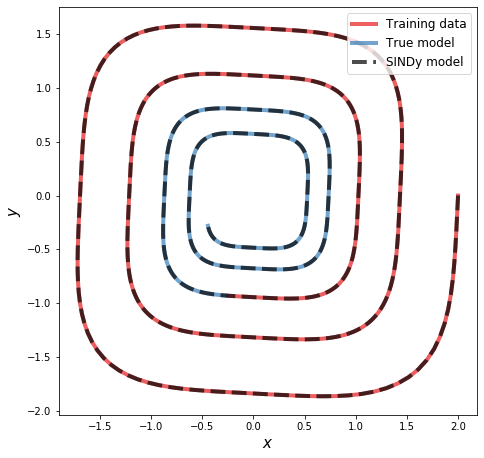

In [6]:
# Simulate and plot the results

z_sim = model.simulate(z0, t)

fig, ax = plt.subplots(1, 1, figsize=(figwidth, figwidth))

ax.plot(z_train[:, 0], z_train[:, 1], color=pal[0], label="Training data", **plot_kws)
ax.plot(
    z[~train_inds, 0], z[~train_inds, 1], color=pal[1], label="True model", **plot_kws
)
ax.plot(z_sim[:, 0], z_sim[:, 1], "k--", label="SINDy model", **plot_kws)
ax.legend(fontsize=12)
ax.set(xlabel="$x$", ylabel="$y$")
helpers.resize_fonts(ax)

if save_plots:
    fname = "figures/nonlinear_oscillator"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

fig.show()

### Learning simplified equations of motion

In [8]:
timesteps = 50
grav = -9.8
drag = -0.5
h0 = 40

# Drag-free trajectory
h_dragfree, t = helpers.synthetic_ball_drop(grav, 0, h0=h0, timesteps=timesteps)
model_dragfree = ps.SINDy(optimizer=ps.STLSQ(threshold=0.1), feature_names=["v"])
v_dragfree = model_dragfree.differentiate(h_dragfree, t)
model_dragfree.fit(v_dragfree, t)

# Linear drag trajectory
h_drag, _ = helpers.synthetic_ball_drop(grav, drag, h0=h0, timesteps=timesteps)
model_drag = ps.SINDy(optimizer=ps.STLSQ(threshold=0.1), feature_names=["v"])
v_drag = model_drag.differentiate(h_drag, t)
model_drag.fit(v_drag, t)

print("Learned model (drag-free training data):")
model_dragfree.print()

print("\nLearned model (linear drag training data):")
model_drag.print()

Learned model (drag-free training data):
v' = -9.800 1

Learned model (linear drag training data):
v' = -9.786 1 + -0.499 v


In [9]:
# Reynolds number dependent drag trajectory
h_re_drag, t = helpers.re_dependent_synthetic_ball_drop(
    0.067, accel=grav, mass=0.057, noise=0, timesteps=timesteps, h0=h0
)

model_re_drag = ps.SINDy(optimizer=ps.STLSQ(threshold=0.004), feature_names=["v"])
v_re_drag = model_re_drag.differentiate(h_re_drag, t)
model_re_drag.fit(v_re_drag, t)

print("Learned drag model (Re-dependent drag training data, small threshold):")
model_re_drag.print()


model_re_drag = ps.SINDy(optimizer=ps.STLSQ(threshold=0.1), feature_names=["v"])
model_re_drag.fit(v_re_drag, t)
print("\nLearned drag model (Re-dependent drag training data, large threshold):")
model_re_drag.print()

Learned drag model (Re-dependent drag training data, small threshold):
v' = -9.810 1 + -0.005 v + 0.017 v^2

Learned drag model (Re-dependent drag training data, large threshold):
v' = -6.345 1


## Numerical differentiation

Plot test data

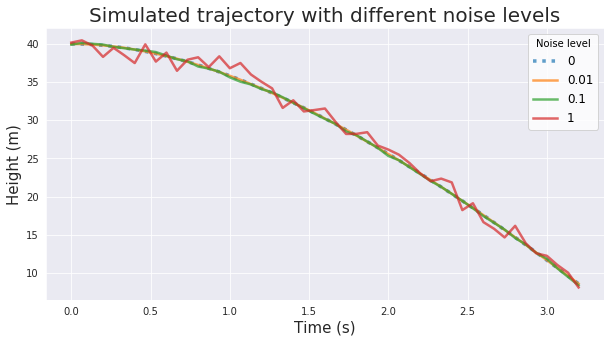

In [10]:
timesteps = 49
grav = -9.8
drag = -0.5

# True height, velocity, and acceleration
h, t = helpers.synthetic_ball_drop(grav, drag, h0=40, timesteps=timesteps)
v = (grav / drag) * (np.exp(drag * t) - 1)
a = grav * np.exp(drag * t)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

noise_levels_plot = [1e-2, 1e-1, 1]

ax.plot(t, h, ":", label=0, alpha=0.7, linewidth=3.5)
for noise in noise_levels_plot:
    ax.plot(
        t, h + noise * np.random.randn(timesteps), label=noise, alpha=0.7, linewidth=2.5
    )

ax.set(
    title="Simulated trajectory with different noise levels",
    xlabel="Time (s)",
    ylabel="Height (m)",
)
ax.legend(title="Noise level", fontsize=12)
helpers.resize_fonts(ax)


# Save results
if save_plots:
    fname = "figures/noisy_trajectory"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

fig.show()

### Comparison of differentiation methods
Plot error as a function of noise level for different numerical differentiation schemes

In [11]:
noise_levels_test = np.logspace(-3, 0, 200)
diff_methods = ["forward difference", "centered difference"]
v_error_unsmoothed = {diff_method: [] for diff_method in diff_methods}
a_error_unsmoothed = {diff_method: [] for diff_method in diff_methods}
v_error_smoothed = {diff_method: [] for diff_method in diff_methods}
a_error_smoothed = {diff_method: [] for diff_method in diff_methods}

for noise in noise_levels_test:
    h_noisy = h + noise * np.random.randn(timesteps)

    for diff_method in diff_methods:
        # Unsmoothed results
        v_approx = helpers.differentiate(h_noisy, t, diff_method=diff_method)
        a_approx = helpers.differentiate(v_approx, t, diff_method=diff_method)

        v_error_unsmoothed[diff_method].append(
            helpers.relative_error(v, v_approx, ord=norm)
        )
        a_error_unsmoothed[diff_method].append(
            helpers.relative_error(a, a_approx, ord=norm)
        )

        # Smoothed results
        v_approx = helpers.differentiate(
            h_noisy, t, diff_method=diff_method, smoother="savgol"
        )
        a_approx = helpers.differentiate(
            v_approx, t, diff_method=diff_method, smoother="savgol"
        )

        v_error_smoothed[diff_method].append(
            helpers.relative_error(v, v_approx, ord=norm)
        )
        a_error_smoothed[diff_method].append(
            helpers.relative_error(a, a_approx, ord=norm)
        )


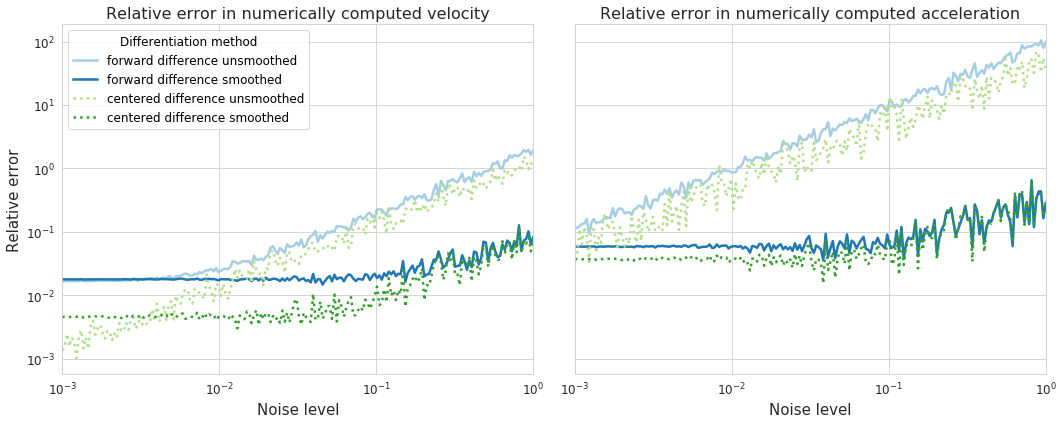

In [12]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(1, 2, figsize=(2 * figwidth, figheight), sharey=True)

custom_cycle = cycler(color=sns.color_palette("Paired", n_colors=10))
axs[0].set_prop_cycle(custom_cycle)
axs[1].set_prop_cycle(custom_cycle)
linestyles = ["-", ":", "-.", "--"]
kwargs = {"linewidth": 2.5}

for k, diff_method in enumerate(diff_methods):
    kwargs["linestyle"] = linestyles[k % len(diff_methods)]
    axs[0].plot(
        noise_levels_test,
        v_error_unsmoothed[diff_method],
        label="{} unsmoothed".format(diff_method),
        **kwargs
    )
    axs[1].plot(
        noise_levels_test,
        a_error_unsmoothed[diff_method],
        label="{} unsmoothed".format(diff_method),
        **kwargs
    )

    axs[0].plot(
        noise_levels_test,
        v_error_smoothed[diff_method],
        label="{} smoothed".format(diff_method),
        **kwargs
    )
    axs[1].plot(
        noise_levels_test,
        a_error_smoothed[diff_method],
        label="{} smoothed".format(diff_method),
        **kwargs
    )

axs[0].set(
    title="Relative error in numerically computed velocity",
    xlabel="Noise level",
    ylabel="Relative error",
    xscale="log",
    yscale="log",
    xlim=(min(noise_levels_test), max(noise_levels_test)),
)
axs[1].set(
    title="Relative error in numerically computed acceleration",
    xlabel="Noise level",
    xscale="log",
    yscale="log",
    xlim=(min(noise_levels_test), max(noise_levels_test)),
)

axs[0].legend(
    title="Differentiation method", loc="upper left", fontsize=12, title_fontsize=12
)

helpers.resize_fonts(axs, title=16, ticks=12)

fig.tight_layout()

# Save results
if save_plots:
    fname = "figures/differentiation_method_comparison"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

fig.show()

### Varying smoothing window

In [13]:
window_lengths = np.arange(7, 36, 4)
v_error = {w: [] for w in window_lengths}
a_error = {w: [] for w in window_lengths}

for noise in noise_levels_test:
    h_noisy = h + noise * np.random.randn(timesteps)

    for window_length in window_lengths:
        v_approx = helpers.differentiate(
            h_noisy,
            t,
            diff_method="centered difference",
            smoother="savgol",
            window_length=window_length,
        )
        a_approx = helpers.differentiate(
            v_approx,
            t,
            diff_method="centered difference",
            smoother="savgol",
            window_length=window_length,
        )

        v_error[window_length].append(helpers.relative_error(v, v_approx, ord=norm))
        a_error[window_length].append(helpers.relative_error(a, a_approx, ord=norm))

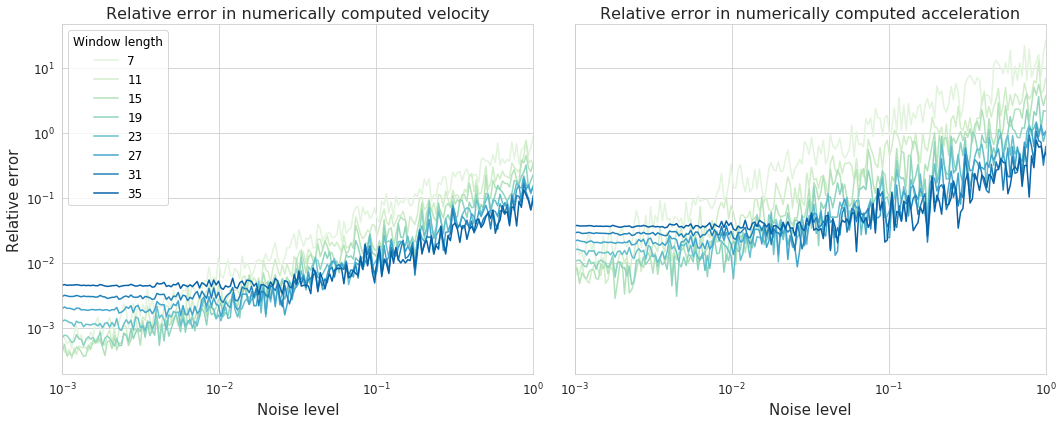

In [14]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(1, 2, figsize=(2 * figwidth, figheight), sharey=True)

custom_cycle = cycler(color=sns.color_palette("GnBu", len(window_lengths)))
axs[0].set_prop_cycle(custom_cycle)
axs[1].set_prop_cycle(custom_cycle)
kwargs = {"linewidth": 1.5}
for window_length in window_lengths:
    axs[0].plot(
        noise_levels_test, v_error[window_length], label=window_length, **kwargs
    )
    axs[1].plot(
        noise_levels_test, a_error[window_length], label=window_length, **kwargs
    )

axs[0].set(
    title="Relative error in numerically computed velocity",
    xlabel="Noise level",
    ylabel="Relative error",
    xscale="log",
    yscale="log",
    xlim=(min(noise_levels_test), max(noise_levels_test)),
)
axs[1].set(
    title="Relative error in numerically computed acceleration",
    xlabel="Noise level",
    xscale="log",
    yscale="log",
    xlim=(min(noise_levels_test), max(noise_levels_test)),
)

axs[0].legend(title="Window length", fontsize=12, title_fontsize=12)

helpers.resize_fonts(axs, title=16, ticks=12)

fig.tight_layout()

# Save results
if save_plots:
    fname = "figures/differentiation_smoothing_window_comparison"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

fig.show()


### Difference between noisy and smoothed data
How much does the smoothed version of a vector differ from the original noisy version?

In [15]:
h_error = {w: [] for w in window_lengths}

for noise in noise_levels_test:
    h_noisy = h + noise * np.random.randn(timesteps)

    for window_length in window_lengths:
        h_smoothed = helpers.smooth_data(
            h_noisy, smoother="savgol", window_length=window_length
        )

        h_error[window_length].append(
            helpers.relative_error(h_noisy, h_smoothed, ord=norm)
        )

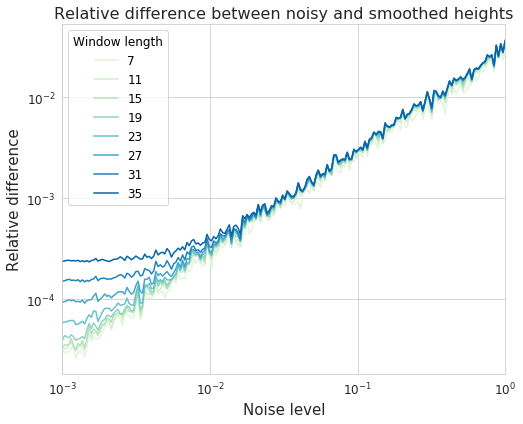

In [16]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(figwidth, figheight))

custom_cycle = cycler(color=sns.color_palette("GnBu", len(window_lengths)))
ax.set_prop_cycle(custom_cycle)
kwargs = {"linewidth": 1.5}
for window_length in window_lengths:
    ax.plot(noise_levels_test, h_error[window_length], label=window_length, **kwargs)

ax.set(
    title="Relative difference between noisy and smoothed heights",
    xlabel="Noise level",
    ylabel="Relative difference",
    xscale="log",
    yscale="log",
    xlim=(min(noise_levels_test), max(noise_levels_test)),
)

ax.legend(title="Window length", fontsize=12, title_fontsize=12)
helpers.resize_fonts(ax, title=16, ticks=12)

fig.tight_layout()

# Save results
if save_plots:
    fname = "figures/smoothing_error"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

fig.show()

### Estimating noise level in original data set
We can estimate the noise level in the original data set by assuming the noise is gaussian and checking the relative difference between the trajectories and their smoothed versions.

In [18]:
# Read in data
data_file = "../data/Ball_drops_data.xls"
bd_data = pd.read_excel(data_file, sheet_name=None)

# Remove bowling ball
del bd_data["Bowling Ball"]
ball_list = bd_data.keys()
n_balls = len(ball_list)

In [19]:
smoother = "savgol"
window_length = 35
h_diff = [{}, {}]

for drop in [1, 2]:
    for ball in bd_data.keys():
        ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]

        h_data = ball_df["Height (m)"].values
        t_data = ball_df["Time (s)"].values

        ntc = helpers.need_to_clip(t_data)
        if ntc:
            h_data = h_data[:ntc]
            t_data = t_data[:ntc]

        h_smoothed = helpers.smooth_data(
            h_data, smoother=smoother, window_length=window_length
        )
        h_diff[drop - 1][ball] = helpers.relative_error(h_data, h_smoothed, ord=norm)

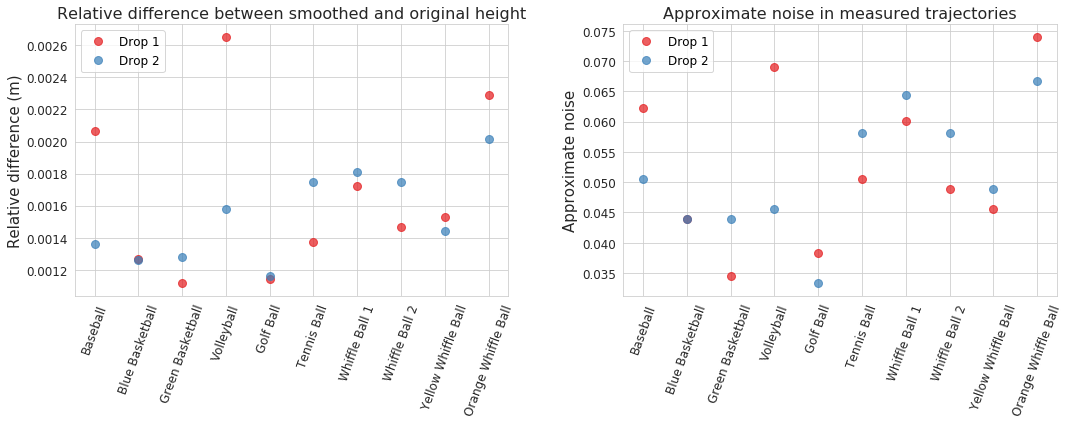

In [20]:
dfs = [pd.DataFrame.from_dict(d, orient="index") for d in h_diff]

with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))

custom_cycle = cycler(color=sns.color_palette("Set1", 2))
axs[0].set_prop_cycle(custom_cycle)
axs[1].set_prop_cycle(custom_cycle)

kwargs = {"alpha": 0.7, "markersize": 8}

for drop in [1, 2]:
    df = dfs[drop - 1]
    # Relative difference between smoothed and unsmoothed height
    axs[0].plot(
        np.arange(n_balls), df.values, "o", label="Drop {}".format(drop), **kwargs
    )

    # Plot approximate noise level for each ball trajectory
    df["approx_noise"] = df.applymap(
        lambda x: noise_levels_test[np.argmin(np.abs(np.array(h_error[35]) - x))]
    )
    axs[1].plot(
        np.arange(n_balls),
        df["approx_noise"].values,
        "o",
        label="Drop {}".format(drop),
        **kwargs
    )


axs[0].set(
    title="Relative difference between smoothed and original height",
    xticks=np.arange(n_balls),
    xticklabels=dfs[0].index,
    ylabel="Relative difference (m)",
)
axs[1].set(
    title="Approximate noise in measured trajectories",
    xticks=np.arange(n_balls),
    xticklabels=dfs[0].index,
    ylabel="Approximate noise",
)

for ax in axs:
    ax.tick_params(axis="x", labelrotation=70)
    ax.legend(loc="upper left", fontsize=12, title_fontsize=12)

helpers.resize_fonts(axs, title=16, ticks=12)

fig.tight_layout()

# Save results
if save_plots:
    fname = "figures/noise_estimation"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

fig.show()


## Effect of varying sparsity parameter

In [21]:
# Plotting parameters
plot_kwargs = {
    "linewidth": 2,
}

# Determine minimum number of timesteps
end_time_idx = 100

for drop in [1, 2]:
    for ball in ball_list:
        ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]
        h = ball_df["Height (m)"].values
        t = ball_df["Time (s)"].values

        ntc = helpers.need_to_clip(t)
        if ntc:
            h = h[:ntc]
            t = t[:ntc]

        if len(t) < end_time_idx:
            end_time_idx = len(t)
            print("Shortened to ", len(t), "for ", ball)

Shortened to  42 for  Baseball


### Unregularized

In [22]:
kwargs = {
    "thresh": 0.05,
    "diff_method": "centered_difference",
    "smoother": "savgol",
    "window_length": 35,
    "remove_const": False,
    "drag_coeff": None,
    "library_type": "polynomial",
}

ball = "Tennis Ball"
threshs = [10, 2, 0.1, 0.005, 0.0045, 0.0035, 0.002]

for thresh in threshs:
    kwargs["thresh"] = thresh
    print("Threshold:", thresh)

    for drop in [1, 2]:
        ball_df = bd_data[ball].loc[bd_data[ball]["Drop #"] == drop]
        h = ball_df["Height (m)"].values
        t = ball_df["Time (s)"].values

        ntc = helpers.need_to_clip(t)
        if ntc:
            h = h[:ntc]
            t = t[:ntc]

        sb = helpers.SINDyBall(**kwargs)
        sb.fit(h, t)
        sb.print_equation()


Threshold: 10
v'  =  0 

v'  =  0 

Threshold: 2
v'  =  (-7.634403*1) 

v'  =  (-7.246446*1) 

Threshold: 0.1
v'  =  (-14.865860*1) + (0.108480*x) + (-0.291449*v) 

v'  =  (-25.364079*1) + (0.310920*x) + (-0.645680*v) 

Threshold: 0.005
v'  =  (-6.106821*1) + (-0.071713*x) + (0.087966*v) + (-0.005983*xv) 

v'  =  (30.823695*1) + (-1.492572*x) + (1.548759*v) + (-0.042731*xv) + (0.013017*x^2) 

Threshold: 0.0045
v'  =  (-2.911633*1) + (-0.138784*x) + (0.086121*v) + (-0.006127*xv) + (-0.004875*v^2) 

v'  =  (30.823695*1) + (-1.492572*x) + (1.548759*v) + (-0.042731*xv) + (0.013017*x^2) 

Threshold: 0.0035
v'  =  (14.799811*1) + (-0.696381*x) + (0.703570*v) + (-0.018287*xv) + (0.003921*x^2) + (-0.006529*v^2) 

v'  =  (30.823695*1) + (-1.492572*x) + (1.548759*v) + (-0.042731*xv) + (0.013017*x^2) 

Threshold: 0.002
v'  =  (45.499758*1) + (-1.474940*x) + (2.482877*v) + (-0.055952*xv) + (0.006762*x^2) + (-0.039314*v^2) + (-0.002170*v^3) 

v'  =  (-570.716488*1) + (29.735702*x) + (-41.032589*v) 

### Regularized

In [23]:
kwargs = {
    "thresh": 1.5,
    "group_sparse_method": "1-norm",
    "normalize": False,
    "plot_error": False,
    "library_type": "polynomial",
    "model_to_subtract": None,
    "test_inds": [0, end_time_idx],
}

threshs = [70, 65, 2, 0.2, 0.14, 0.1, 0.05, 0.04, 0.02, 0.01, 0.005]

for thresh in threshs:
    kwargs["thresh"] = thresh
    print("Threshold:", thresh)

    with warnings.catch_warnings():  # Suppres ODEintWarning
        warnings.filterwarnings("ignore")

        helpers.test_group_sparsity(bd_data, drops=[1], plot_drop=2, **kwargs)

        helpers.test_group_sparsity(bd_data, drops=[2], plot_drop=1, **kwargs)

Threshold: 70
Average equation: 
v'  =  0 

Average equation: 
v'  =  0 

Threshold: 65
Average equation: 
v'  =  (-6.976657*1) 

Average equation: 
v'  =  (-6.743516*1) 

Threshold: 2
Average equation: 
v'  =  (-8.349103*1) + (-0.150070*v) 

Average equation: 
v'  =  (-8.654535*1) + (-0.193314*v) 

Threshold: 0.2
Average equation: 
v'  =  (-15.654965*1) + (0.133644*x) + (-0.384081*v) 

Average equation: 
v'  =  (-11.036164*1) + (0.044351*x) + (-0.269179*v) 

Threshold: 0.14
Average equation: 
v'  =  (-2.052348*1) + (-0.145590*x) + (0.448742*v) + (-0.014277*xv) 

Average equation: 
v'  =  (-11.036164*1) + (0.044351*x) + (-0.269179*v) 

Threshold: 0.1
Average equation: 
v'  =  (1.521654*1) + (-0.218427*x) + (0.465371*v) + (-0.013518*xv) + (0.001166*v^2) 

Average equation: 
v'  =  (6.645849*1) + (-0.326837*x) + (0.798574*v) + (-0.018881*xv) 

Threshold: 0.05
Average equation: 
v'  =  (-13.194688*1) + (0.241267*x) + (-0.665452*v) + (0.008090*xv) + (-0.003243*x^2) + (-0.009241*v^2) 

Aver

## Realistic falling ball simulations

In [25]:
data_file = "../data/Ball_drops_data.xls"
bd_data = pd.read_excel(data_file, sheet_name=None)

# Remove bowling ball
del bd_data["Bowling Ball"]
ball_list = list(bd_data.keys())

# Circumference was measured in cm
circumference = {
    "Baseball": 22.25,
    "Blue Basketball": 75.0,
    "Green Basketball": 73.25,
    "Volleyball": np.NaN,
    "Golf Ball": 13.8,
    "Tennis Ball": 20.75,
    "Whiffle Ball 1": 22.8,
    "Whiffle Ball 2": 22.8,
    "Yellow Whiffle Ball": 29.0,
    "Orange Whiffle Ball": 29.0,
}

# Convert circumference to radius (m)
radius = {key: value / (100 * 2 * np.pi) for key, value in circumference.items()}


# Weight was measured in oz
weight = {
    "Baseball": 5,
    "Blue Basketball": 18,
    "Green Basketball": 16,
    "Volleyball": np.NaN,
    "Golf Ball": 1.6,
    "Tennis Ball": 2,
    "Whiffle Ball 1": 1,
    "Whiffle Ball 2": 1,
    "Yellow Whiffle Ball": 1.5,
    "Orange Whiffle Ball": 1.5,
}

# Convert weight to mass (kg)
mass_dict = {key: 0.0283495 * value for key, value in weight.items()}

### Generate synthetic data set
Note that one can modify the simulations by setting the following parameters of `helpers.re_dependent_synthetic_ball_drop`.
* `diameter`: Diameter of the ball (m)
* `mass`: Mass of the ball (kg)
* `timesteps`: total number of time steps
* `dt`: the size of each time step (s)
* `air_density`: density of the air (kg / m$^3$)

In [26]:
# Generate representative example balls
balls = ["Golf Ball", "Tennis Ball", "Whiffle Ball 1", "Baseball", "Blue Basketball"]
diameters = [2 * radius[ball] for ball in balls]
masses = [mass_dict[ball] for ball in balls]

noise_levels = [0, 0.01, 0.1, 0.5, 1, 2]

seed = 100
np.random.seed(seed=seed)

synthetic_data = OrderedDict()

for k, dm in enumerate(zip(diameters, masses)):
    diameter, mass = dm
    ball_string = "Ball " + str(k + 1)
    ball_df = pd.DataFrame(columns=["Time (s)", "Height (m)", "Drop #"])
    for noise in noise_levels:
        h, t = helpers.re_dependent_synthetic_ball_drop(
            diameter, mass=mass, noise=noise
        )
        temp_df = pd.DataFrame.from_dict({"Time (s)": t, "Height (m)": h})
        temp_df["Drop #"] = noise
        ball_df = ball_df.append(temp_df, ignore_index=True)

    synthetic_data[ball_string] = ball_df

### Collect coefficients when group sparsity is enforced

In [27]:
kwargs = {
    "thresh": 1.0,
    "group_sparse_method": "1-norm",
    "plot_error": False,
    "library_type": "polynomial",
    "window_length": 35,
}

all_coefficient_list = []
for k in range(len(noise_levels)):
    all_coefficient_list.append({ball: {"1": []} for ball in synthetic_data.keys()})

with warnings.catch_warnings():  # Suppres ODEintWarning
    warnings.filterwarnings("ignore")

    for k, noise in enumerate(noise_levels):
        gs_error = helpers.test_group_sparsity(
            synthetic_data,
            drops=[noise_levels[k]],
            plot_drop=noise_levels[k],
            all_coefficient_dict=all_coefficient_list[k],
            **kwargs
        )

gs_dfs = [
    pd.DataFrame.from_dict(cd, orient="index").applymap(lambda l: l[0]).transpose()
    for cd in all_coefficient_list
]

Average equation: 
v'  =  (-11.529829*1) + (-0.427742*v) 

Average equation: 
v'  =  (-11.529528*1) + (-0.427961*v) 

Average equation: 
v'  =  (-11.640894*1) + (-0.440551*v) 

Average equation: 
v'  =  (-11.282549*1) + (-0.411736*v) 

Average equation: 
v'  =  (13.867141*1) + (-0.422922*x) + (0.418991*v) 

Average equation: 
v'  =  (-16.522958*1) + (0.072483*x) + (-0.506983*v) 



### Collect coefficients when group sparsity is not enforced

In [28]:
library = {
    "1": lambda x, v: 1,
    "x": lambda x, v: x,
    "v": lambda x, v: v,
    "xv": lambda x, v: x * v,
    "x^2": lambda x, v: x ** 2,
    "v^2": lambda x, v: v ** 2,
    "x^2v": lambda x, v: (x ** 2) * v,
    "xv^2": lambda x, v: x * (v ** 2),
    "x^3": lambda x, v: x ** 3,
    "v^3": lambda x, v: v ** 3,
}

kwargs = {
    "thresh": 0.15,
    "diff_method": "centered_difference",
    "smoother": "savgol",
    "window_length": 35,
    "remove_const": False,
    "drag_coeff": None,
    "library_type": "polynomial",
}

vanilla_dfs = []
for drop in noise_levels:
    df = pd.DataFrame(index=library.keys())
    for ball in synthetic_data.keys():
        ball_df = synthetic_data[ball].loc[synthetic_data[ball]["Drop #"] == drop]

        h = ball_df["Height (m)"].values
        t = ball_df["Time (s)"].values

        ntc = helpers.need_to_clip(t)
        if ntc:
            h = h[:ntc]
            t = t[:ntc]

        sb = helpers.SINDyBall(**kwargs)
        sb.fit(h, t)

        coeffs = sb.get_xi()
        labels = sb.get_labels()
        coeff_series = pd.Series(coeffs, index=labels, name=ball)
        df[ball] = coeff_series

    vanilla_dfs.append(df)

### Generate coefficient heatmaps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


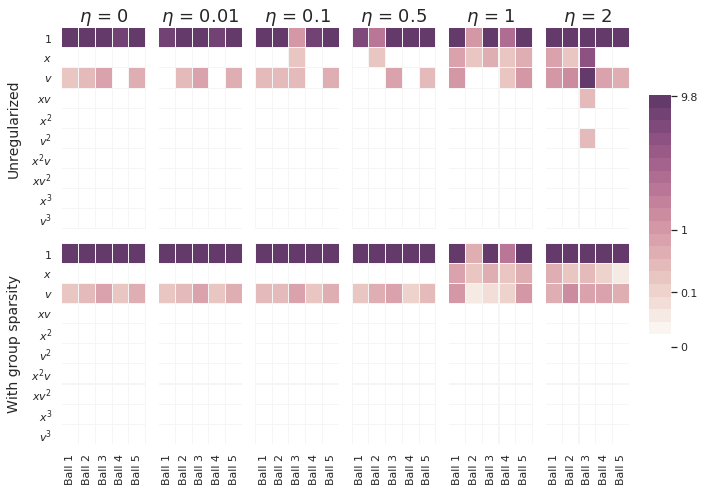

In [29]:
# Get rid of ticks
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Generate the heatmaps and put in one figure
n_tests = len(noise_levels)
title_fontsize = 18
axes_fontsize = 14

cbar_tick_labels = [0, 0.1, 1, 9.8]
cbar_ticks = [np.cbrt(l) for l in cbar_tick_labels]
cbar_tick_labels = list(map(str, cbar_tick_labels))

tex_labels = np.array(["$" + s + "$" for s in gs_dfs[0].index])
heatmap_args = {
    "yticklabels": tex_labels,
    "vmin": 0,
    "vmax": np.cbrt(10),
    "cmap": sns.cubehelix_palette(20, dark=0.3, light=1),
    "linewidths": 0.1,
    "linecolor": "whitesmoke",
}


fig, axs = plt.subplots(2, n_tests, figsize=(10, 7), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.5])

# This heatmap's entries define the colorbar
sns.heatmap(
    np.cbrt(np.abs(vanilla_dfs[0])),
    ax=axs[0, 0],
    cbar_ax=cbar_ax,
    cbar_kws={"ticks": cbar_ticks},
    **heatmap_args,
)
for k in range(1, n_tests):
    sns.heatmap(
        np.cbrt(np.abs(vanilla_dfs[k])), ax=axs[0, k], cbar=False, **heatmap_args
    )

for k in range(n_tests):
    sns.heatmap(np.cbrt(np.abs(gs_dfs[k])), ax=axs[1, k], cbar=False, **heatmap_args)


for ax in axs.flatten():
    ax.tick_params(axis="y", rotation=0)

# Annotate
for k in range(n_tests):
    axs[0, k].set_title(f"$\eta$ = {noise_levels[k]}", fontsize=title_fontsize)

axs[0, 0].set_ylabel("Unregularized", fontsize=axes_fontsize, labelpad=10)
axs[1, 0].set_ylabel("With group sparsity", fontsize=axes_fontsize, labelpad=10)

cbar_ax.set_yticklabels(cbar_tick_labels)

fig.tight_layout(rect=[0, 0, 0.9, 1])

if save_plots:
    fname = "figures/synthetic_heatmaps_realistic_drag"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

plt.show()

### Comparison of trajectories

In [30]:
sns.reset_defaults()

pal = sns.color_palette("Set1", n_colors=4)
plot_kws = {"alpha": 0.7, "linewidth": 3}

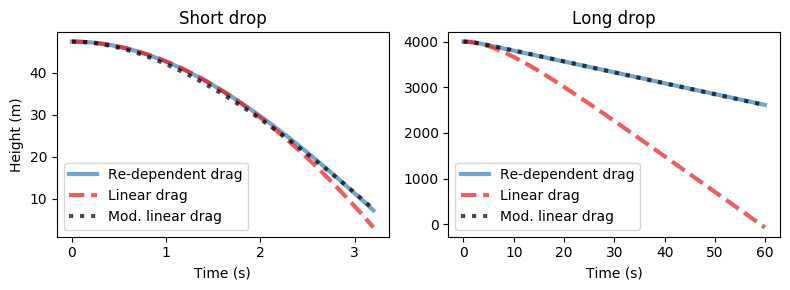

In [31]:
timesteps = 900
h0 = 4000

# Get linear drag trajectory
h_l_short, t_l_short = helpers.synthetic_ball_drop(-9.8, drag=-0.125, noise=0)
h_l_long, t_l_long = helpers.synthetic_ball_drop(
    -9.8, drag=-0.125, noise=0, timesteps=timesteps, h0=h0
)

# Get modified linear drag trajectory
h_ml_short, t_ml_short = helpers.synthetic_ball_drop(-12.7, drag=-0.53, noise=0)
h_ml_long, t_ml_long = helpers.synthetic_ball_drop(
    -12.7, drag=-0.53, noise=0, timesteps=timesteps, h0=h0
)

# Get Re-dependent drag trajectory
h_q_short, t_q_short = helpers.re_dependent_synthetic_ball_drop(
    0.067, mass=0.057, noise=0
)
h_q_long, t_q_long = helpers.re_dependent_synthetic_ball_drop(
    0.067, mass=0.057, noise=0, timesteps=timesteps, h0=h0
)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(t_q_short, h_q_short, label="Re-dependent drag", color=pal[1], **plot_kws)
axs[0].plot(t_l_short, h_l_short, "--", label="Linear drag", color=pal[0], **plot_kws)
axs[0].plot(
    t_ml_short, h_ml_short, ":", label="Mod. linear drag", color="black", **plot_kws
)

axs[0].set(xlabel="Time (s)", ylabel="Height (m)", title="Short drop")

axs[1].plot(t_q_long, h_q_long, label="Re-dependent drag", color=pal[1], **plot_kws)
axs[1].plot(t_l_long, h_l_long, "--", label="Linear drag", color=pal[0], **plot_kws)
axs[1].plot(
    t_ml_long, h_ml_long, ":", label="Mod. linear drag", color="black", **plot_kws
)
axs[1].set(xlabel="Time (s)", title="Long drop")


axs[0].legend()
axs[1].legend()
fig.tight_layout()

if save_plots:
    fname = "figures/drag_comparison"
    plt.savefig(fname + ".pdf", bbox_inches="tight", pad_inches=0)

fig.show()